
Choose

 1) P to play

 2) A for the agent to play

 3) S to stop



for how many episodes, enter integer


The agent won 38.28 %  lost 56.51 %  got a draw 5.21 %  of games played
The agent achieved a total reward of -817588.5


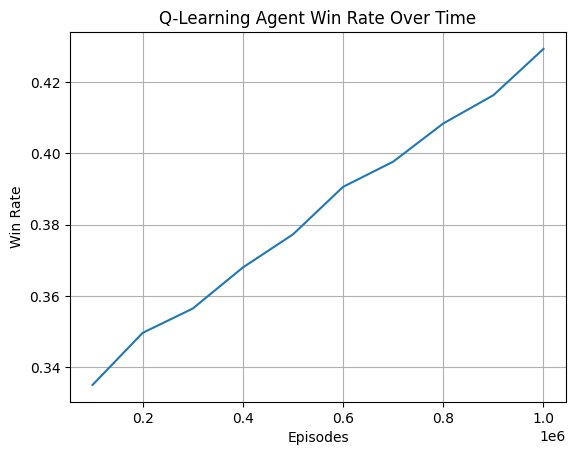

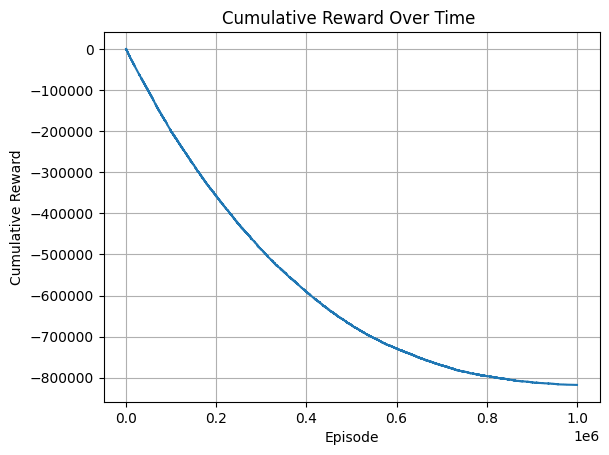

The agent won 38.28 %  lost 56.51 %  got a draw 5.21 %  of games played
The agent achieved a total reward of -209939.5


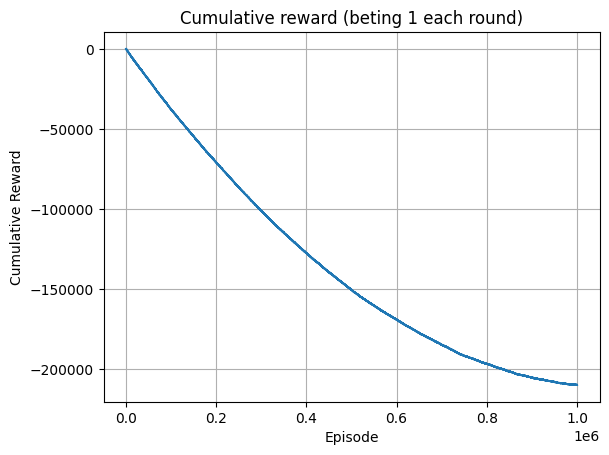

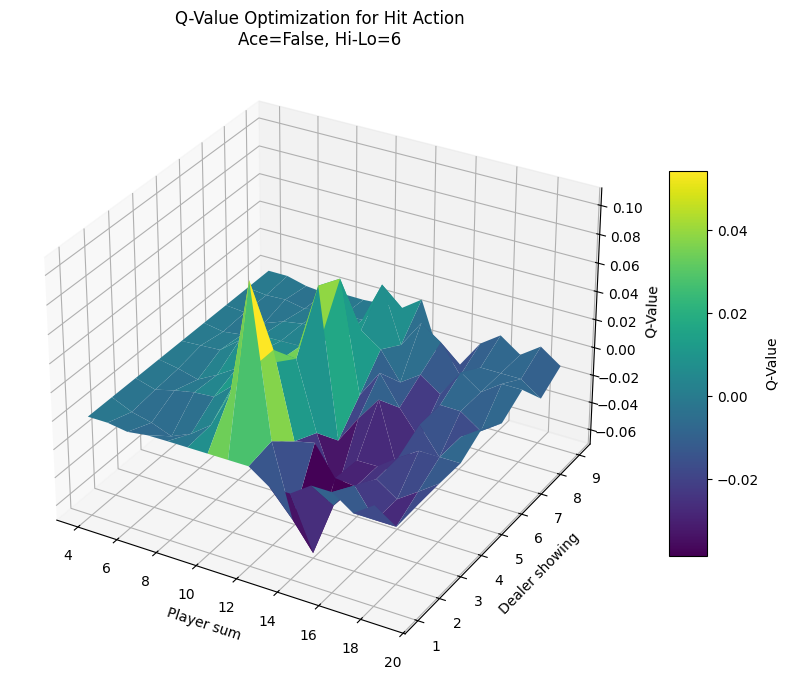

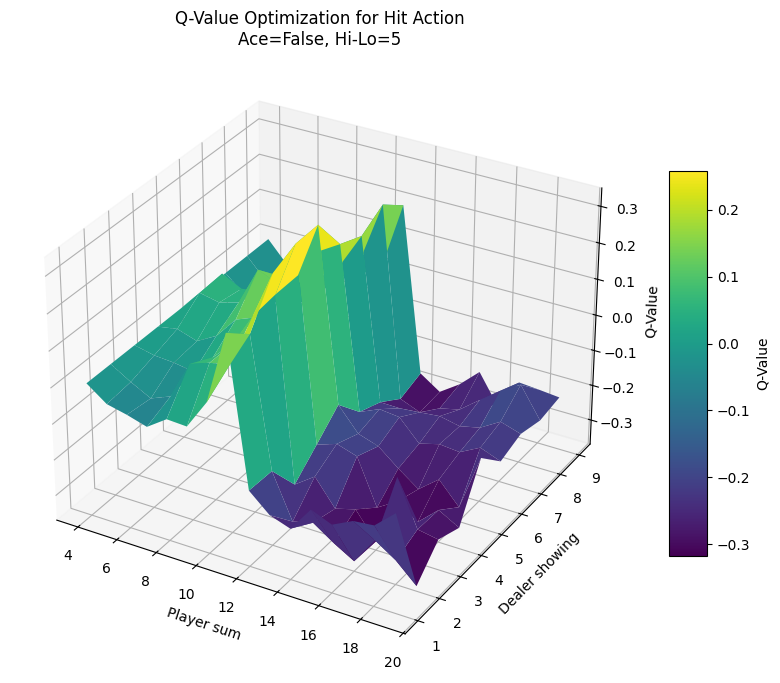

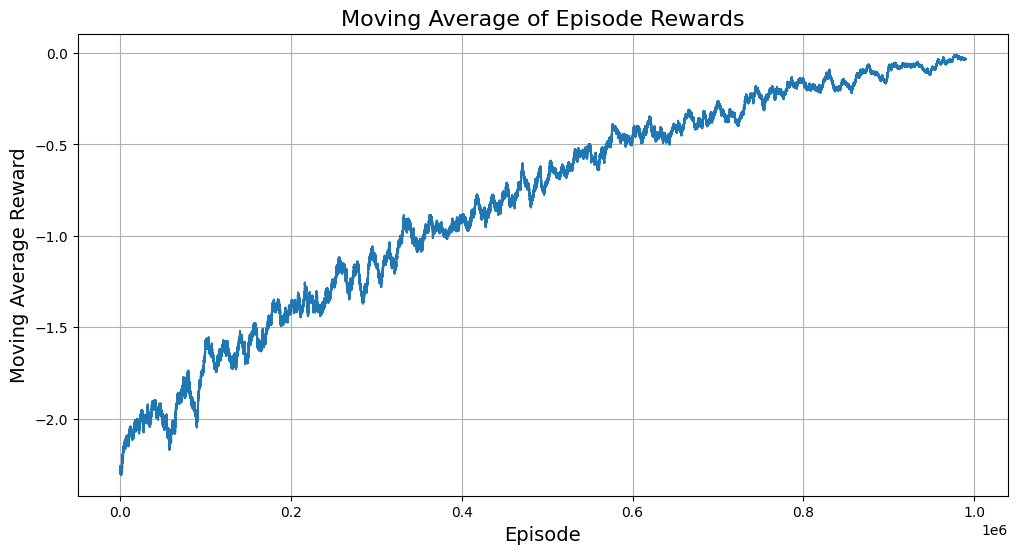


continue with evaluation, Yes or No


Choose episode number
The agent won 43.40 %  lost 49.68 %  got a draw 6.92 %  of games played
The agent achieved a total reward of -2802.0


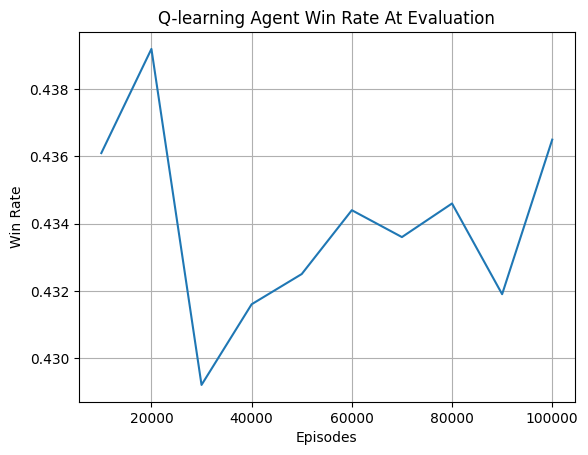

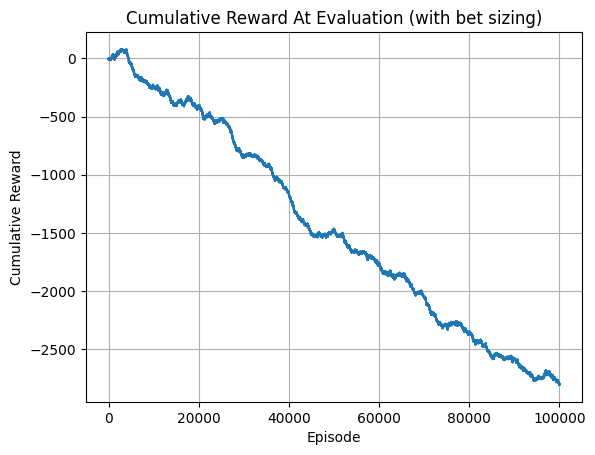

The agent won 43.40 %  lost 49.68 %  got a draw 6.92 %  of games played
The agent achieved a total reward of -2802.0


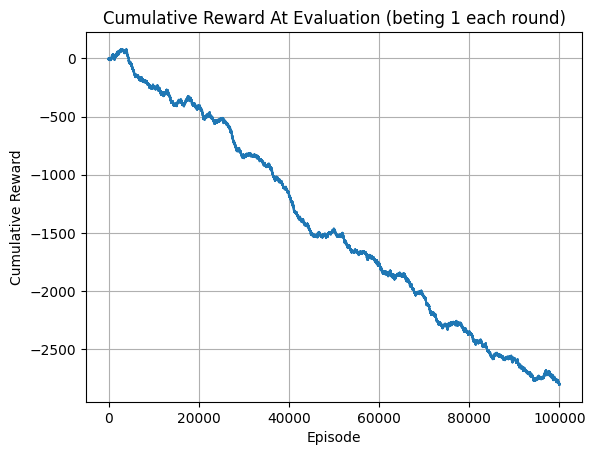

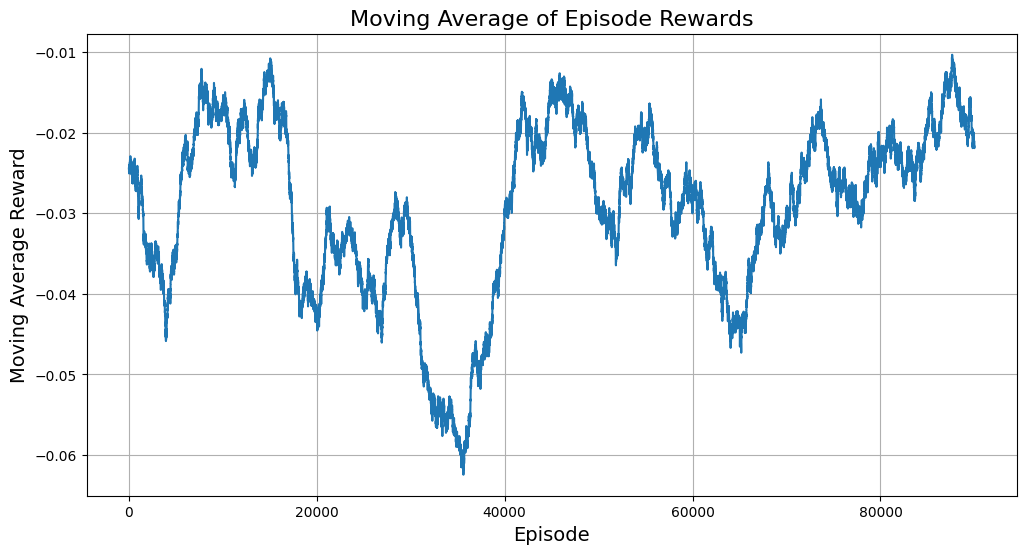


continue with evaluation, Yes or No



Choose

 1) P to play

 2) A for the agent to play

 3) S to stop




In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

##########################################################################################################################################################################
#---------------------------------------------------------------------visualise metrics--------------------------------------------------------------
##########################################################################################################################################################################
def visualise_q_table(q_table, action):
    if action == "Hit":
        action = 0

    ace_status = 0
    
    # Prepare axes
    player_sums = np.arange(4, 20)   # 4 to 20
    dealer_cards = np.arange(1, 10)  # 1 to 10
    X, Y = np.meshgrid(player_sums, dealer_cards)
    
    # Visualize for Hi-Lo values 6 and 5
    for hi_lo in [6, 5]:
        Z = np.zeros_like(X, dtype=float)
        for i, p in enumerate(player_sums):
            for j, d in enumerate(dealer_cards):
                Z[j, i] = q_table[p-4, d-1, ace_status, hi_lo, action]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Q-Value')
        ax.set_title(f'Q-Value Optimization for {["Hit","Stand","Double Down"][action]} Action\nAce={bool(ace_status)}, Hi-Lo={hi_lo}')
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Q-Value')
        plt.show()

def visualise_av_reward(rewards):
    length_step = 10000
    rewards = np.array(rewards).flatten()

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title('Moving Average of Episode Rewards', fontsize=16)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Moving Average Reward', fontsize=14)

    reward_moving_average = np.convolve(rewards, np.ones(length_step) / length_step, mode="valid")
    ax.plot(range(len(reward_moving_average)), reward_moving_average)
    ax.grid(True)
    plt.show()

def visualise(episodes, results, eval, which):
    win_rates = []
    window_size = episodes // 10    
    for i in range(10):
        start = i * window_size
        end = (i + 1) * window_size
        window_results = results[start:end]
        win_count = sum(1 for x in window_results if x > 0)
        win_rate = win_count / window_size
        win_rates.append(win_rate)

    win_counter = 0
    loss_counter = 0 
    draw_counter = 0
    for i in results:
        if i >0 :
            win_counter +=1
        elif i == 0 :
            draw_counter += 1
        else:
            loss_counter +=1

    print("The agent won", f"{100*win_counter/episodes:.2f}","%  lost", f"{100*loss_counter/episodes:.2f}","%  got a draw", f"{100*draw_counter/episodes:.2f}","%  of games played")

    if which is None:
        plt.figure(1)
        plt.plot([(i + 1) * window_size for i in range(10)], win_rates)
        plt.xlabel('Episodes')
        plt.ylabel('Win Rate')
        if eval == None:
            plt.title('Q-Learning Agent Win Rate Over Time')
        else: plt.title('Q-learning Agent Win Rate At Evaluation')
        plt.grid()

    print("The agent achieved a total reward of", sum(results))
    
    cumulative_rewards = np.cumsum(results)
    plt.figure(2)
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    if eval == None and which == None:
        plt.title('Cumulative Reward Over Time ')
    elif eval is None and which is not None:
        plt.title('Cumulative reward (beting 1 each round)')
    elif eval is not None and which is None: 
        plt.title('Cumulative Reward At Evaluation (with bet sizing)')
    elif eval is not None and which is not None: 
        plt.title('Cumulative Reward At Evaluation (beting 1 each round)')
    plt.grid()        
    plt.show()

    ##########################################################################################################################################################################
#---------------------------------------------------------------------update prepwork---------------------------------------------------------
##########################################################################################################################################################################
def Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, reward, eval, q_table, terminal_state):

    if eval is not None:
        return q_table

    if(agent_or_player == "A" and prev_players_card_value>3):
        cur_players_card_value = actual_player_cards_value
        if isinstance(player_cards_value, list):
            cur_Ace = 1
        else: cur_Ace = 0
        #print("UPDATE: current cards value:",cur_players_card_value, "dealers first card:",dealers_first_card, "if we have an ace:",cur_Ace,"previous cards value:", prev_players_card_value, "if we previously had an ace:",prev_Ace, "action taken:",action_taken, "reward received:",reward, "cur Hi Lo:", cur_Hi_lo, "prev Hi Lo:", prev_Hi_lo)
        new_q_table = update_q_table(q_table, cur_players_card_value, dealers_first_card, cur_Ace, prev_players_card_value, prev_Ace, action_taken, reward, cur_Hi_lo, prev_Hi_lo, terminal_state)
        q_table = new_q_table

        return q_table
    
    else:
        return q_table
    
##########################################################################################################################################################################
#---------------------------------------------------------------------compute Hi-Lo---------------------------------------------------------
##########################################################################################################################################################################
def compute_Hi_Lo(player_cards, dealers_cards, Running_count, dealt_cards):
    total_cards = 0
    for card in dealt_cards:
        total_cards += dealt_cards[card]
    
    remaining_decks = 208/total_cards


    for card in player_cards:
        if card in ["2", "3", "4", "5", "6"]:
            Running_count += 1
        elif card in ["10", "J", "Q", "K", "A"]:
            Running_count -=1

    for card in dealers_cards:
        if card in ["2", "3", "4", "5", "6"]:
            Running_count += 1
        elif card in ["10", "J", "Q", "K", "A"]:
            Running_count -=1
    
    #print(remaining_decks)
    #print(Running_count)

    Running_count = math.ceil(Running_count/remaining_decks)

    if Running_count >= 5:
        Hi_Lo = 6
    elif Running_count == 4 or Running_count == 3:
        Hi_Lo = 5
    elif Running_count == 2 or Running_count == 1:
        Hi_Lo = 4
    elif Running_count == 0:
        Hi_Lo = 3
    elif Running_count == -1 or Running_count == -2:
        Hi_Lo = 2
    elif Running_count == -3 or Running_count == -4:
        Hi_Lo = 1
    elif Running_count <= -5:
        Hi_Lo = 0

    #print(Running_count)
    return Hi_Lo, Running_count

##########################################################################################################################################################################
#-----------------------------------------------------Check if the player or agent is at or over 21 without aces---------------------------------------------------------
##########################################################################################################################################################################
def check_21(player_cards_value, agent_or_player):
    if not isinstance(player_cards_value, list):
        if player_cards_value>21:
            if agent_or_player == "P":
                print("You have", player_cards_value,"which is over 21, you lost!")
            return -1
        elif player_cards_value == 21:
            if agent_or_player == "P":
                print("You have 21 which means you won!")
            return 1
    elif isinstance(player_cards_value, list):
        if player_cards_value[0]>21 and player_cards_value[1]>21:
            if agent_or_player == "P":
                print("You have", min(player_cards_value),"which is over 21, you lost!")
            return -1
        elif player_cards_value[0] == 21 or player_cards_value[1] == 21:
            if agent_or_player == "P":
                print("You have 21 which means you won!")
            return 1
    return None

##########################################################################################################################################################################
#-----------------------------------------------------Check if dealer is at or over 21 without aces-------------------------------------------------------------------------
##########################################################################################################################################################################
def is_dealer_at_or_over_21(dealer_cards_value, agent_or_player):
    if dealer_cards_value == 21:
        if agent_or_player == "P":
            print("dealer has 21, you lost...")
        return -1
    elif dealer_cards_value > 21:
        if agent_or_player == "P":
            print("dealer has", dealer_cards_value,"which is over 21, you won!")
        return 1

##########################################################################################################################################################################
#--------------------------------------------------------------Check who wins-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def check_who_wins(dealer_cards_value, player_cards_value, agent_or_player):
    chance = is_dealer_at_or_over_21(dealer_cards_value, agent_or_player)
    if(chance == 1 or chance == -1):
            return chance
    if player_cards_value>dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is more than the dealer's value:", dealer_cards_value, "you won!")
        return 1
    elif player_cards_value<dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is less than the dealer's value:", dealer_cards_value, "you lost...")
        return -1
    elif player_cards_value==dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is the same as dealer's value:", dealer_cards_value, "it's a tie...")
        return 0
    
##########################################################################################################################################################################
#--------------------------------------------------------------Dealers turn-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards):
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------case that the dealer doesnt have aces---------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    if not isinstance(dealer_cards_value, list):
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #-----------------------------------------dealer doesnt have to draw extra card because he is between 17 and 20--------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        if dealer_cards_value<=20 and dealer_cards_value>=17:
            if agent_or_player == "P":
                print("dealer doesn't draw an extra card as his card's value is between 17 and 20")
            return dealer_cards_value, dealer_cards, dealt_cards
        #--------------------------------------------------------dealer is at 21----------------------------------------------------------------------------------
        elif dealer_cards_value == 21:
            return 21, dealer_cards, dealt_cards
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------dealer draws extra card because he is below 16------------------------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        elif dealer_cards_value<=16:
            actual_dealer_cards_value = dealer_cards_value
            while actual_dealer_cards_value <= 16:
                if agent_or_player == "P":
                    print("dealer has to draw an extra card as his card's value is 16 or less")
                while(True):   
                    new_card = random.sample(list(cards.keys()), 1)[0]
                    dealt_cards[new_card] +=1
                    if dealt_cards[new_card] <= 16:
                        break
                    else:
                        dealt_cards[new_card] -= 1

                dealer_cards.append(new_card)
                dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)
                actual_dealer_cards_value = dealer_cards_value

                #----------------------------------------------case where dealer draws an ace-------------------------------------------------------------------
                if isinstance(dealer_cards_value, list):
                    #print(dealer_cards_value)
                    #-----------------------------dealer has an ace and his highest value is over 21 and his lowest value is less than, or 21-----------------------
                    if max(dealer_cards_value)>21:
                        actual_dealer_cards_value = min(dealer_cards_value)
                    #---------------------dealer has an ace and his highest value is less than, or 21-------------------------------------------------------------
                    if max(dealer_cards_value)<=21:
                        actual_dealer_cards_value =  max(dealer_cards_value)
                    
            return actual_dealer_cards_value, dealer_cards, dealt_cards
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #-----------------------------------------case that the dealer has one or more Aces------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    if isinstance(dealer_cards_value, list):
        if max(dealer_cards_value)>21:
            actual_dealer_cards_value = min(dealer_cards_value)
        elif max(dealer_cards_value)<=21:
            actual_dealer_cards_value = max(dealer_cards_value)
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #-----------------------------------------dealer doesnt have to draw extra card because he is between 17 and 20--------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        if actual_dealer_cards_value<=20 and actual_dealer_cards_value>=17:
            if agent_or_player == "P":
                print("dealer doesn't draw an extra card as his card's value is between 17 and 20")
            return actual_dealer_cards_value, dealer_cards, dealt_cards
        #--------------------------------------------------------dealer is at 21----------------------------------------------------------------------------------
        elif 21 in dealer_cards_value:
            return 21, dealer_cards, dealt_cards
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------dealer draws extra card because he is below 16------------------------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        elif actual_dealer_cards_value<=16:
            while actual_dealer_cards_value <= 16:
                if agent_or_player == "P":
                    print("dealer has to draw an extra card as his card's value is 16 or less")
                while(True):   
                    new_card = random.sample(list(cards.keys()), 1)[0]
                    dealt_cards[new_card] +=1
                    if dealt_cards[new_card] <= 16:
                        break
                    else:
                        dealt_cards[new_card] -= 1

                dealer_cards.append(new_card)
                dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

                #-------------------------------------------------------case where dealer doesnt draw ace--------------------------------------------------------------
                if not isinstance(dealer_cards_value, list):
                    actual_dealer_cards_value = dealer_cards_value
                #----------------------------------------------case where dealer draws an ace-------------------------------------------------------------------
                elif isinstance(dealer_cards_value, list):
                    #-----------------------------dealer has an ace and his highest value is over 21 and his lowest value is less than, or 21-----------------------
                    if max(dealer_cards_value)>21:
                        actual_dealer_cards_value = min(dealer_cards_value)
                    #---------------------dealer has an ace and his highest value is less than, or 21-------------------------------------------------------------
                    if max(dealer_cards_value)<=21:
                        actual_dealer_cards_value = max(dealer_cards_value)
            return actual_dealer_cards_value, dealer_cards, dealt_cards
        
##########################################################################################################################################################################
#--------------------------------------------------------------Computing Value Porcess-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def compute_value(player_cards, cards, who, agent_or_player):
    if "A" not in player_cards:
        player_cards_value = sum(cards[card] for card in player_cards)

        if agent_or_player == "P":
            if who == "p":
                print("lets see our cards")
                for card in player_cards:
                    print("My card:", card)
                print("My cards value:", player_cards_value, "\n\n")
            elif who == "d":
                print("lets see the dealer's cards")
                for card in player_cards:
                    print("Dealer's card:", card)
                print("Dealer's cards value:", player_cards_value, "\n\n")
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------Handling Aces-----------------------------------------------------------------------------------------------------
    elif player_cards.count("A")>=1:
        player_cards_value = [player_cards.count("A") + sum(cards[card] for card in player_cards if card!="A"), player_cards.count("A")+10 + sum(cards[card] for card in player_cards if card!="A")]
    
        if agent_or_player == "P":
            if who == "p":
                for card in player_cards:
                    print("My card:", card)
                print("Since one or more of my cards is an Ace, my cards have multiple values")
                for value in player_cards_value:
                    print("My cards value:", value, "\n\n")
            elif who == "d":
                for card in player_cards:
                    print("Dealer's card:", card)
                print("Since one or more of dealer's cards is an Ace, his cards have multiple values")
                for value in player_cards_value:
                    print("Dealer's cards value:", value, "\n\n")

    return player_cards_value

##########################################################################################################################################################################
#-----------------------------------------------------Find players actual card value--------------------------------------------------------------------------------
##########################################################################################################################################################################
def find_actual_value(player_cards_value):
    if isinstance(player_cards_value, list):
        if max(player_cards_value)>21:
            actual_player_cards_value = min(player_cards_value)
        elif max(player_cards_value)<21:
            actual_player_cards_value = max(player_cards_value)
        elif(21 in player_cards_value):
            actual_player_cards_value = 21
    else: actual_player_cards_value = player_cards_value
    return actual_player_cards_value

##########################################################################################################################################################################
# -----------------------------------------------------------------Update bet_table--------------------------------------------------------------------------------------
##########################################################################################################################################################################
def update_bet_table(bet_table, reward, betting_choice):
    #print(bet_table, reward, betting_choice)
    bet = betting_choice - 1
    old_value = bet_table[0, betting_choice-1]
    bet_table[0, betting_choice-1] +=0.01*(reward*bet - old_value)

    return bet_table
##########################################################################################################################################################################
# ------------------------------------------------------Update q_table using bellman's equation--------------------------------------------------------------------------
##########################################################################################################################################################################
def update_q_table(q_table, cur_players_card_value, dealers_first_card, cur_Ace, prev_players_card_value, prev_Ace, action_taken, reward, cur_Hi_lo, prev_Hi_lo, terminal_state):
    alpha = 0.01
    gamma = 0.95
    
    if terminal_state is None:
        best_future_q_value = np.max(q_table[cur_players_card_value-4, dealers_first_card-1, cur_Ace, cur_Hi_lo])
        #print("cur players value:", cur_players_card_value,"dealers first card:", dealers_first_card,"cur ace:", cur_Ace,"cur hi lo:", cur_Hi_lo)
        old_q_value = q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, prev_Hi_lo, action_taken]
        new_q_value = old_q_value+alpha*(reward + gamma*best_future_q_value - old_q_value)
        q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, prev_Hi_lo, action_taken] = new_q_value
        #print("prev players value:", prev_players_card_value,"dealers first card:", dealers_first_card,"prev ace:", prev_Ace,"prev hi lo:", prev_Hi_lo,"action:", action_taken)

    elif terminal_state is not None:
        old_q_value = q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, prev_Hi_lo, action_taken]
        new_q_value = old_q_value+alpha*(reward - old_q_value)

        q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, prev_Hi_lo, action_taken] = new_q_value
        #print("prev players value:", prev_players_card_value,"dealers first card:", dealers_first_card,"prev ace:", prev_Ace,"prev hi lo:", prev_Hi_lo,"action:", action_taken)

    return q_table
##########################################################################################################################################################################
#-----------------------------------------------------The next betting action the agent will take-------------------------------------------------------------------------
##########################################################################################################################################################################
def betting_action(bet_table, episode, episodes, eval):
    epsilon = max(0.01, 1.0 - (episode+1) / episodes)
    #print("eval",eval)

    if np.random.rand()< epsilon and eval is None:
        betting_choice = np.random.randint(1, 11)
    else:
        betting_choice = np.argmax(bet_table[0]) + 1
    
    #print("betting choice, inside the betting action",betting_choice)
    return betting_choice

##########################################################################################################################################################################
#-----------------------------------------------------The next action the agent will take--------------------------------------------------------------------------------
##########################################################################################################################################################################
def agents_next_action(q_table,dealers_first_card, player_cards_value, episode,episodes, eval, Hi_Lo, cards_length):
    epsilon = max(0.01, 1.0 - (episode +1) / episodes)

    action_map = {0: "H", 1: "S", 2: "D"}
    
    if isinstance(player_cards_value, list):
        Ace = 1
    else: Ace = 0

    actual_player_cards_value = find_actual_value(player_cards_value)

    if cards_length > 2:
        if np.random.rand()< epsilon and eval == None:
            choice = np.random.choice(["H", "S"])
        else:
            q_values = q_table[actual_player_cards_value-4, dealers_first_card-1, Ace, Hi_Lo]
            #print("players value:", actual_player_cards_value,"dealers first card:", dealers_first_card,"ace:", Ace,"hi lo:", Hi_Lo)
            q_values = q_values[:2] 
            action = np.argmax(q_values)
            choice = action_map[action]
            #print(choice)

    elif np.random.rand()< epsilon and eval == None:
        choice = np.random.choice(["H", "S", "D"])
    else:
        #print(actual_player_cards_value, dealers_first_card, Ace, Hi_Lo)
        action = np.argmax(q_table[actual_player_cards_value-4, dealers_first_card-1, Ace, Hi_Lo])
        #print("players value:", actual_player_cards_value,"dealers first card:", dealers_first_card,"ace:", Ace,"hi lo:", Hi_Lo)
        choice = action_map[action]
        #print(choice)

    return choice

##########################################################################################################################################################################
#--------------------------------------------------------------Playing Porcess-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def play(agent_or_player, episode, episodes, q_table, bet_table, eval_flag, Running_count, dealt_cards):

    player_cards_value = 0
    dealer_cards_value = 0

    cards = {"2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9, "10": 10, "J": 10, "Q": 10, "K": 10, "A": (1,11)}

    player_cards = []
    dealer_cards = []

    while(True):   
        player_cards = random.sample(list(cards.keys()), 2)
        dealt_cards[player_cards[0]] +=1
        dealt_cards[player_cards[1]] +=1
        if dealt_cards[player_cards[0]] <= 16 and dealt_cards[player_cards[1]] <=16:
            break
        else:
            dealt_cards[player_cards[0]] -= 1
            dealt_cards[player_cards[1]] -= 1

    #print("fiest agents cards",player_cards)
    
    player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)

    while(True):   
        dealer_cards = random.sample(list(cards.keys()), 2)
        dealt_cards[dealer_cards[0]] +=1
        dealt_cards[dealer_cards[1]] +=1
        if dealt_cards[dealer_cards[0]] <= 16 and dealt_cards[dealer_cards[1]] <=16:
            break
        else:
            dealt_cards[dealer_cards[0]] -= 1
            dealt_cards[dealer_cards[1]] -= 1
    #print("first delars card",dealer_cards[0])

    Hi_Lo, Running_count = compute_Hi_Lo(player_cards, [dealer_cards[0]], Running_count, dealt_cards)
    #print("hi lo:", Hi_Lo, "running count", Running_count)

#---------------------------------------------------------------compute value of dealer-----------------------------------------------
  #----save this if tha agent is playing----
    if isinstance(cards[dealer_cards[0]], tuple):
        dealers_first_card = 1
    else:   dealers_first_card = cards[dealer_cards[0]]

    if "A" != dealer_cards[0]:
        if agent_or_player == "P":
            print("First of dealer's cards:", dealer_cards[0],"and its value:", cards[dealer_cards[0]], "\n\n")
    elif "A" == dealer_cards[0]:
        if agent_or_player == "P": 
            print("Since the first of dealer's cards is an Ace:", dealer_cards[0], "there are two possible values: 1, 11 \n\n")

#-----------------------------------------------------------------------------------------------------------------------------------------------------    
#----------------------------------------------------setup is finished, playing begins here----------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------
    #----save this if tha agent is playing----
    choice = None
    action_taken = None
    prev_players_card_value = find_actual_value(player_cards_value)
    actual_player_cards_value = find_actual_value(player_cards_value)
    if isinstance(player_cards_value, list):
        prev_Ace = 1
    else: prev_Ace = 0

    while(True):
        if agent_or_player == "A" and action_taken is None:
            betting_choice = betting_action(bet_table, episode, episodes, eval_flag) 

        reward = check_21(player_cards_value, agent_or_player)

        if reward == 1 and action_taken is None:
            reward = 1.5
            break
        elif reward is not None and agent_or_player == "P":
            break 
        #---------------------------------------------------------------The player chooses--------------------------------------------------------------------
        if(agent_or_player == "P"):
            betting_choice = 1
            print("Choose to stay or draw another card\n\n")
            choice = input(" Type S to stay or H to hit or D to double down ")
        #--------------------------------------------------------------The agent chooses------------------------------------------------------------------------
        elif(agent_or_player == "A"):
            #print("CHOICE: dealers card:",dealers_first_card, "players card value:",player_cards_value,"Hi Lo:", Hi_Lo, "num of episode:", episode, "total episodes:", episodes)
            choice = agents_next_action(q_table, dealers_first_card, player_cards_value, episode,episodes, eval_flag, Hi_Lo, len(player_cards))
            #print("agents choice",choice)

        if choice == "S":
            action_taken = 1
            
            actual_player_cards_value = find_actual_value(player_cards_value)
        
            dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

            dealers_final_value, dealer_cards, dealt_cards = dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards)
            
            #-----------------------------------------------------------check who wins----------------------------------------------------
            reward = check_who_wins(dealers_final_value, actual_player_cards_value, agent_or_player)
            #-------------------------------------------the agent is playing--------------------------------
            terminal_state = 1
            prev_Hi_lo = Hi_Lo
            Hi_Lo, Running_count = compute_Hi_Lo([], dealer_cards[1:], Running_count, dealt_cards)
            cur_Hi_lo = Hi_Lo
            q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, reward, eval_flag, q_table, terminal_state)
            
            #print("S",player_cards, dealer_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            break                
            #-----------------------------------------------------------------------------------------------

        elif choice == "H":
        #-----------save this if tha agent is playing--------------
            reward = None
            action_taken = 0
            prev_players_card_value = find_actual_value(player_cards_value)
            if isinstance(player_cards_value, list):
                prev_Ace = 1
            else: prev_Ace = 0                
        #----------------------------------------------------------
            while(True):   
                new_card = random.sample(list(cards.keys()), 1)[0]
                dealt_cards[new_card] +=1
                if dealt_cards[new_card] <= 16:
                    break
                else:
                    dealt_cards[new_card] -= 1

            player_cards.append(new_card)
            player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)
            actual_player_cards_value = find_actual_value(player_cards_value)
            
            reward = check_21(player_cards_value, agent_or_player)
            prev_Hi_lo = Hi_Lo
            Hi_Lo, Running_count = compute_Hi_Lo([new_card], [], Running_count, dealt_cards)
            cur_Hi_lo = Hi_Lo
        
            if reward is not None:
                terminal_state = 1
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, reward, eval_flag, q_table, terminal_state)
                #print("H",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
                break
            elif reward is None:
                terminal_state = None
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, 0, eval_flag, q_table, terminal_state)
                #print("H",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            #-------------------------------------------------------------------------------------------

        elif choice == "D":
            reward = None
            action_taken = 2
            prev_players_card_value = find_actual_value(player_cards_value)
            if isinstance(player_cards_value, list):
                prev_Ace = 1
            else: prev_Ace = 0                
        #----------------------------------------------------------
            while(True):   
                new_card = random.sample(list(cards.keys()), 1)[0]
                dealt_cards[new_card] +=1
                if dealt_cards[new_card] <= 16:
                    break
                else:
                    dealt_cards[new_card] -= 1

            player_cards.append(new_card)
            player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)
            actual_player_cards_value = find_actual_value(player_cards_value)
 
            reward = check_21(player_cards_value, agent_or_player)
            prev_Hi_lo = Hi_Lo
        
            if reward is not None:
                reward *= 2
                terminal_state = 1
                Hi_Lo, Running_count = compute_Hi_Lo([new_card], [], Running_count, dealt_cards)
                cur_Hi_lo = Hi_Lo
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, reward, eval_flag, q_table, terminal_state)
                #print("D",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
                break
            
            dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

            dealers_final_value, dealer_cards, dealt_cards = dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards)
            
            #-----------------------------------------------------------check who wins----------------------------------------------------
            reward = check_who_wins(dealers_final_value, actual_player_cards_value, agent_or_player)
            reward *= 2
            #-------------------------------------------the agent is playing--------------------------------
            terminal_state = 1
            Hi_Lo, Running_count = compute_Hi_Lo([new_card], dealer_cards[1:], Running_count, dealt_cards)
            cur_Hi_lo = Hi_Lo
            q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, cur_Hi_lo, prev_Hi_lo, reward, eval_flag, q_table, terminal_state) 
            
            #print("D",player_cards, dealer_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            break                
            #----------------------------------------------------------------------------------------------

        
        else: print("Not a choice choose again")

    if agent_or_player == "A" and eval_flag == None:
        new_bet_table = update_bet_table(bet_table, reward, int(betting_choice))
        bet_table = new_bet_table
    
    #print("hi lo",Hi_Lo,"running count", Running_count)
    #print("reward, betting choice, reward*betting choice", reward, betting_choice, reward*betting_choice)

    return reward*betting_choice,reward, q_table, bet_table, Running_count, dealt_cards, betting_choice

###################################################################################################################################################################################
###-----------------------------------------------------------------------------------MAIN---------------------------------------------------------------------------------
###################################################################################################################################################################################
def main():
    while(True):
        print("\nChoose\n\n 1) P to play\n\n 2) A for the agent to play\n\n 3) S to stop\n\n")
        mode = input("Choose 1) P to play 2) A for the agent to play 3) S to stop")
        if mode == "S":
            break

        elif mode == "P":
            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
            Running_Count = 0
            play("P", None, None, None, None, None, Running_Count, dealt_cards)
        elif mode == "A":
            print("\nfor how many episodes, enter integer\n\n")
            episodes = int(input("Choose episode number"))
            # table dimensions: (player cards value 4–20) x (first dealers card 1–10) x (one of our cards is an Ace False/True) x (Hi-Lo) x (actions Hit/Stick/Double down)
            """
            the way i have implemented comput value and find actual value 4 is the lowest possible value 
            becauese if there is an ace and a three compute value will return 3,13 and find actual value will onlu keep 13
            no need to keep a slot for 21 in q table as is is a terminal state, the agent wins
            """
            q_table = np.zeros((17, 10, 2, 7, 3))
            #(betting ammount 1-10)
            bet_table = np.zeros((1, 10))
            Running_Count = 0
            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
            results = []
            rewards = []
            bets = []
            

            for episode in range(0,episodes):
                reward, result, q_table, bet_table, Running_Count, dealt_cards, bet = play("A", episode, episodes, q_table, bet_table, None, Running_Count, dealt_cards)
                results.append(result)
                rewards.append(reward)
                if reward != 0:
                    bets.append(bet)
                
                reshuffle_sum = 0
                for card in dealt_cards:
                    reshuffle_sum += dealt_cards[card]
                #print("reshuffle sum",reshuffle_sum,"\n\n\n")
                #print(dealt_cards)
                if reshuffle_sum >= 156:
                    Running_Count = 0
                    reshuffle_sum = 0
                    dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}

            visualise(episodes, rewards, None, None)
            visualise(episodes, results, None, 1)

            visualise_q_table(q_table, "Hit")

            visualise_av_reward(rewards)
            
            while(True):
                print("\ncontinue with evaluation, Yes or No\n\n")
                inp = input("Y/N")
                if inp == "Y":
                    print("Choose episode number")
                    episodes = int(input("Choose episode number"))
                    eval_results = []
                    eval_rewards = []
                    bets = []
                    Running_Count = 0
                    dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
                    

                    for episode in range(0,episodes):
                        reward, result, q_table, bet_table, Running_Count, dealt_cards, bet = play("A", episode, episodes, q_table, bet_table, 1, Running_Count, dealt_cards)
                        eval_results.append(result)
                        eval_rewards.append(reward)
                        if reward != 0:
                            bets.append(bet)

                        reshuffle_sum = 0     
                        for card in dealt_cards:
                            reshuffle_sum += dealt_cards[card]
                        if reshuffle_sum >= 156:
                            Running_Count = 0
                            reshuffle_sum = 0
                            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}

                    visualise(episodes, eval_rewards, 1, None)

                    visualise(episodes, eval_results, 1, 1)

                    visualise_av_reward(eval_rewards)
                else:
                    break
           
        else : print("not a choice, choose again")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

##########################################################################################################################################################################
#---------------------------------------------------------------------visualise metrics--------------------------------------------------------------
##########################################################################################################################################################################
def visualise_av_reward(rewards):
    length_step = 10000
    rewards = np.array(rewards).flatten()

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title('Moving Average of Episode Rewards', fontsize=16)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel('Moving Average Reward', fontsize=14)

    reward_moving_average = np.convolve(rewards, np.ones(length_step) / length_step, mode="valid")
    ax.plot(range(len(reward_moving_average)), reward_moving_average)
    ax.grid(True)
    plt.show()

def visualise(episodes, results, eval, which):
    win_rates = []
    window_size = episodes // 10    
    for i in range(10):
        start = i * window_size
        end = (i + 1) * window_size
        window_results = results[start:end]
        win_count = sum(1 for x in window_results if x > 0)
        win_rate = win_count / window_size
        win_rates.append(win_rate)

    win_counter = 0
    loss_counter = 0 
    draw_counter = 0
    for i in results:
        if i >0 :
            win_counter +=1
        elif i == 0 :
            draw_counter += 1
        else:
            loss_counter +=1

    print("The agent won", f"{100*win_counter/episodes:.2f}","%  lost", f"{100*loss_counter/episodes:.2f}","%  got a draw", f"{100*draw_counter/episodes:.2f}","%  of games played")

    if which is None:
        plt.figure(1)
        plt.plot([(i + 1) * window_size for i in range(10)], win_rates)
        plt.xlabel('Episodes')
        plt.ylabel('Win Rate')
        if eval == None:
            plt.title('Q-Learning Agent Win Rate Over Time')
        else: plt.title('Q-learning Agent Win Rate At Evaluation')
        plt.grid()

    print("The agent achieved a total reward of", sum(results))
    
    cumulative_rewards = np.cumsum(results)
    plt.figure(2)
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    if eval == None and which == None:
        plt.title('Cumulative Reward Over Time ')
    elif eval is None and which is not None:
        plt.title('Cumulative reward (beting 1 each round)')
    elif eval is not None and which is None: 
        plt.title('Cumulative Reward At Evaluation (with bet sizing)')
    elif eval is not None and which is not None: 
        plt.title('Cumulative Reward At Evaluation (beting 1 each round)')
    plt.grid()        
    plt.show()

    ##########################################################################################################################################################################
#---------------------------------------------------------------------update prepwork---------------------------------------------------------
##########################################################################################################################################################################
def Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, reward, eval, q_table, terminal_state):

    if eval is not None:
        return q_table

    if(agent_or_player == "A" and prev_players_card_value>3):
        cur_players_card_value = actual_player_cards_value
        if isinstance(player_cards_value, list):
            cur_Ace = 1
        else: cur_Ace = 0
        #print("UPDATE: current cards value:",cur_players_card_value, "dealers first card:",dealers_first_card, "if we have an ace:",cur_Ace,"previous cards value:", prev_players_card_value, "if we previously had an ace:",prev_Ace, "action taken:",action_taken, "reward received:",reward, "cur Hi Lo:", cur_Hi_lo, "prev Hi Lo:", prev_Hi_lo)
        new_q_table = update_q_table(q_table, cur_players_card_value, dealers_first_card, cur_Ace, prev_players_card_value, prev_Ace, action_taken, reward, terminal_state)
        q_table = new_q_table

        return q_table
    
    else:
        return q_table
##########################################################################################################################################################################
#-----------------------------------------------------Check if the player or agent is at or over 21 without aces---------------------------------------------------------
##########################################################################################################################################################################
def check_21(player_cards_value, agent_or_player):
    if not isinstance(player_cards_value, list):
        if player_cards_value>21:
            if agent_or_player == "P":
                print("You have", player_cards_value,"which is over 21, you lost!")
            return -1
        elif player_cards_value == 21:
            if agent_or_player == "P":
                print("You have 21 which means you won!")
            return 1
    elif isinstance(player_cards_value, list):
        if player_cards_value[0]>21 and player_cards_value[1]>21:
            if agent_or_player == "P":
                print("You have", min(player_cards_value),"which is over 21, you lost!")
            return -1
        elif player_cards_value[0] == 21 or player_cards_value[1] == 21:
            if agent_or_player == "P":
                print("You have 21 which means you won!")
            return 1
    return None

##########################################################################################################################################################################
#-----------------------------------------------------Check if dealer is at or over 21 without aces-------------------------------------------------------------------------
##########################################################################################################################################################################
def is_dealer_at_or_over_21(dealer_cards_value, agent_or_player):
    if dealer_cards_value == 21:
        if agent_or_player == "P":
            print("dealer has 21, you lost...")
        return -1
    elif dealer_cards_value > 21:
        if agent_or_player == "P":
            print("dealer has", dealer_cards_value,"which is over 21, you won!")
        return 1

##########################################################################################################################################################################
#--------------------------------------------------------------Check who wins-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def check_who_wins(dealer_cards_value, player_cards_value, agent_or_player):
    chance = is_dealer_at_or_over_21(dealer_cards_value, agent_or_player)
    if(chance == 1 or chance == -1):
            return chance
    if player_cards_value>dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is more than the dealer's value:", dealer_cards_value, "you won!")
        return 1
    elif player_cards_value<dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is less than the dealer's value:", dealer_cards_value, "you lost...")
        return -1
    elif player_cards_value==dealer_cards_value:
        if agent_or_player == "P":
            print("You have", player_cards_value,"which is the same as dealer's value:", dealer_cards_value, "it's a tie...")
        return 0
    
##########################################################################################################################################################################
#--------------------------------------------------------------Dealers turn-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards):
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------case that the dealer doesnt have aces---------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    if not isinstance(dealer_cards_value, list):
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #-----------------------------------------dealer doesnt have to draw extra card because he is between 17 and 20--------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        if dealer_cards_value<=20 and dealer_cards_value>=17:
            if agent_or_player == "P":
                print("dealer doesn't draw an extra card as his card's value is between 17 and 20")
            return dealer_cards_value, dealer_cards, dealt_cards
        #--------------------------------------------------------dealer is at 21----------------------------------------------------------------------------------
        elif dealer_cards_value == 21:
            return 21, dealer_cards, dealt_cards
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------dealer draws extra card because he is below 16------------------------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        elif dealer_cards_value<=16:
            actual_dealer_cards_value = dealer_cards_value
            while actual_dealer_cards_value <= 16:
                if agent_or_player == "P":
                    print("dealer has to draw an extra card as his card's value is 16 or less")
                while(True):   
                    new_card = random.sample(list(cards.keys()), 1)[0]
                    dealt_cards[new_card] +=1
                    if dealt_cards[new_card] <= 16:
                        break
                    else:
                        dealt_cards[new_card] -= 1

                dealer_cards.append(new_card)
                dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)
                actual_dealer_cards_value = dealer_cards_value

                #----------------------------------------------case where dealer draws an ace-------------------------------------------------------------------
                if isinstance(dealer_cards_value, list):
                    #print(dealer_cards_value)
                    #-----------------------------dealer has an ace and his highest value is over 21 and his lowest value is less than, or 21-----------------------
                    if max(dealer_cards_value)>21:
                        actual_dealer_cards_value = min(dealer_cards_value)
                    #---------------------dealer has an ace and his highest value is less than, or 21-------------------------------------------------------------
                    if max(dealer_cards_value)<=21:
                        actual_dealer_cards_value =  max(dealer_cards_value)
                    
            return actual_dealer_cards_value, dealer_cards, dealt_cards
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #-----------------------------------------case that the dealer has one or more Aces------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------
    if isinstance(dealer_cards_value, list):
        if max(dealer_cards_value)>21:
            actual_dealer_cards_value = min(dealer_cards_value)
        elif max(dealer_cards_value)<=21:
            actual_dealer_cards_value = max(dealer_cards_value)
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #-----------------------------------------dealer doesnt have to draw extra card because he is between 17 and 20--------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        if actual_dealer_cards_value<=20 and actual_dealer_cards_value>=17:
            if agent_or_player == "P":
                print("dealer doesn't draw an extra card as his card's value is between 17 and 20")
            return actual_dealer_cards_value, dealer_cards, dealt_cards
        #--------------------------------------------------------dealer is at 21----------------------------------------------------------------------------------
        elif 21 in dealer_cards_value:
            return 21, dealer_cards, dealt_cards
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------dealer draws extra card because he is below 16------------------------------------------------------------
        #----------------------------------------------------------------------------------------------------------------------------------------------------------
        elif actual_dealer_cards_value<=16:
            while actual_dealer_cards_value <= 16:
                if agent_or_player == "P":
                    print("dealer has to draw an extra card as his card's value is 16 or less")
                while(True):   
                    new_card = random.sample(list(cards.keys()), 1)[0]
                    dealt_cards[new_card] +=1
                    if dealt_cards[new_card] <= 16:
                        break
                    else:
                        dealt_cards[new_card] -= 1

                dealer_cards.append(new_card)
                dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

                #-------------------------------------------------------case where dealer doesnt draw ace--------------------------------------------------------------
                if not isinstance(dealer_cards_value, list):
                    actual_dealer_cards_value = dealer_cards_value
                #----------------------------------------------case where dealer draws an ace-------------------------------------------------------------------
                elif isinstance(dealer_cards_value, list):
                    #-----------------------------dealer has an ace and his highest value is over 21 and his lowest value is less than, or 21-----------------------
                    if max(dealer_cards_value)>21:
                        actual_dealer_cards_value = min(dealer_cards_value)
                    #---------------------dealer has an ace and his highest value is less than, or 21-------------------------------------------------------------
                    if max(dealer_cards_value)<=21:
                        actual_dealer_cards_value = max(dealer_cards_value)
            return actual_dealer_cards_value, dealer_cards, dealt_cards
        
##########################################################################################################################################################################
#--------------------------------------------------------------Computing Value Porcess-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def compute_value(player_cards, cards, who, agent_or_player):
    if "A" not in player_cards:
        player_cards_value = sum(cards[card] for card in player_cards)

        if agent_or_player == "P":
            if who == "p":
                print("lets see our cards")
                for card in player_cards:
                    print("My card:", card)
                print("My cards value:", player_cards_value, "\n\n")
            elif who == "d":
                print("lets see the dealer's cards")
                for card in player_cards:
                    print("Dealer's card:", card)
                print("Dealer's cards value:", player_cards_value, "\n\n")
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------Handling Aces-----------------------------------------------------------------------------------------------------
    elif player_cards.count("A")>=1:
        player_cards_value = [player_cards.count("A") + sum(cards[card] for card in player_cards if card!="A"), player_cards.count("A")+10 + sum(cards[card] for card in player_cards if card!="A")]
    
        if agent_or_player == "P":
            if who == "p":
                for card in player_cards:
                    print("My card:", card)
                print("Since one or more of my cards is an Ace, my cards have multiple values")
                for value in player_cards_value:
                    print("My cards value:", value, "\n\n")
            elif who == "d":
                for card in player_cards:
                    print("Dealer's card:", card)
                print("Since one or more of dealer's cards is an Ace, his cards have multiple values")
                for value in player_cards_value:
                    print("Dealer's cards value:", value, "\n\n")

    return player_cards_value

##########################################################################################################################################################################
#-----------------------------------------------------Find players actual card value--------------------------------------------------------------------------------
##########################################################################################################################################################################
def find_actual_value(player_cards_value):
    if isinstance(player_cards_value, list):
        if max(player_cards_value)>21:
            actual_player_cards_value = min(player_cards_value)
        elif max(player_cards_value)<21:
            actual_player_cards_value = max(player_cards_value)
        elif(21 in player_cards_value):
            actual_player_cards_value = 21
    else: actual_player_cards_value = player_cards_value
    return actual_player_cards_value

##########################################################################################################################################################################
# -----------------------------------------------------------------Update bet_table--------------------------------------------------------------------------------------
##########################################################################################################################################################################
def update_bet_table(bet_table, reward, betting_choice):
    #print(bet_table, reward, betting_choice)
    bet = betting_choice - 1
    old_value = bet_table[0, betting_choice-1]
    bet_table[0, betting_choice-1] +=0.01*(reward*bet - old_value)

    return bet_table
##########################################################################################################################################################################
# ------------------------------------------------------Update q_table using bellman's equation--------------------------------------------------------------------------
##########################################################################################################################################################################
def update_q_table(q_table, cur_players_card_value, dealers_first_card, cur_Ace, prev_players_card_value, prev_Ace, action_taken, reward, terminal_state):
    alpha = 0.01
    gamma = 0.95
    
    if terminal_state is None:
        best_future_q_value = np.max(q_table[cur_players_card_value-4, dealers_first_card-1, cur_Ace])
        #print("cur players value:", cur_players_card_value,"dealers first card:", dealers_first_card,"cur ace:", cur_Ace,"cur hi lo:", cur_Hi_lo)
        old_q_value = q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, action_taken]
        new_q_value = old_q_value+alpha*(reward + gamma*best_future_q_value - old_q_value)
        q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, action_taken] = new_q_value
        #print("prev players value:", prev_players_card_value,"dealers first card:", dealers_first_card,"prev ace:", prev_Ace,"prev hi lo:", prev_Hi_lo,"action:", action_taken)

    elif terminal_state is not None:
        old_q_value = q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, action_taken]
        new_q_value = old_q_value+alpha*(reward - old_q_value)

        q_table[prev_players_card_value-4, dealers_first_card-1, prev_Ace, action_taken] = new_q_value
        #print("prev players value:", prev_players_card_value,"dealers first card:", dealers_first_card,"prev ace:", prev_Ace,"prev hi lo:", prev_Hi_lo,"action:", action_taken)

    return q_table
##########################################################################################################################################################################
#-----------------------------------------------------The next betting action the agent will take-------------------------------------------------------------------------
##########################################################################################################################################################################
def betting_action(bet_table, episode, episodes, eval):
    epsilon = max(0.01, 1.0 - (episode+1) / episodes)
    #print("eval",eval)

    if np.random.rand()< epsilon and eval is None:
        betting_choice = np.random.randint(1, 11)
    else:
        betting_choice = np.argmax(bet_table[0]) + 1
    
    #print("betting choice, inside the betting action",betting_choice)
    return betting_choice

##########################################################################################################################################################################
#-----------------------------------------------------The next action the agent will take--------------------------------------------------------------------------------
##########################################################################################################################################################################
def agents_next_action(q_table,dealers_first_card, player_cards_value, episode,episodes, eval, cards_length):
    epsilon = max(0.01, 1.0 - (episode +1) / episodes)

    action_map = {0: "H", 1: "S", 2: "D"}
    
    if isinstance(player_cards_value, list):
        Ace = 1
    else: Ace = 0

    actual_player_cards_value = find_actual_value(player_cards_value)

    if cards_length > 2:
        if np.random.rand()< epsilon and eval == None:
            choice = np.random.choice(["H", "S"])
        else:
            q_values = q_table[actual_player_cards_value-4, dealers_first_card-1, Ace]
            #print("players value:", actual_player_cards_value,"dealers first card:", dealers_first_card,"ace:", Ace,"hi lo:", Hi_Lo)
            q_values = q_values[:2] 
            action = np.argmax(q_values)
            choice = action_map[action]
            #print(choice)

    elif np.random.rand()< epsilon and eval == None:
        choice = np.random.choice(["H", "S", "D"])
    else:
        #print(actual_player_cards_value, dealers_first_card, Ace, Hi_Lo)
        action = np.argmax(q_table[actual_player_cards_value-4, dealers_first_card-1, Ace])
        #print("players value:", actual_player_cards_value,"dealers first card:", dealers_first_card,"ace:", Ace,"hi lo:", Hi_Lo)
        choice = action_map[action]
        #print(choice)

    return choice

##########################################################################################################################################################################
#--------------------------------------------------------------Playing Porcess-------------------------------------------------------------------------------------
##########################################################################################################################################################################
def play(agent_or_player, episode, episodes, q_table, bet_table, eval_flag, dealt_cards):

    player_cards_value = 0
    dealer_cards_value = 0

    cards = {"2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9, "10": 10, "J": 10, "Q": 10, "K": 10, "A": (1,11)}

    player_cards = []
    dealer_cards = []

    while(True):   
        player_cards = random.sample(list(cards.keys()), 2)
        dealt_cards[player_cards[0]] +=1
        dealt_cards[player_cards[1]] +=1
        if dealt_cards[player_cards[0]] <= 16 and dealt_cards[player_cards[1]] <=16:
            break
        else:
            dealt_cards[player_cards[0]] -= 1
            dealt_cards[player_cards[1]] -= 1

    #print("fiest agents cards",player_cards)
    
    player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)

    while(True):   
        dealer_cards = random.sample(list(cards.keys()), 2)
        dealt_cards[dealer_cards[0]] +=1
        dealt_cards[dealer_cards[1]] +=1
        if dealt_cards[dealer_cards[0]] <= 16 and dealt_cards[dealer_cards[1]] <=16:
            break
        else:
            dealt_cards[dealer_cards[0]] -= 1
            dealt_cards[dealer_cards[1]] -= 1
    #print("first delars card",dealer_cards[0]
#---------------------------------------------------------------compute value of dealer-----------------------------------------------
  #----save this if tha agent is playing----
    if isinstance(cards[dealer_cards[0]], tuple):
        dealers_first_card = 1
    else:   dealers_first_card = cards[dealer_cards[0]]

    if "A" != dealer_cards[0]:
        if agent_or_player == "P":
            print("First of dealer's cards:", dealer_cards[0],"and its value:", cards[dealer_cards[0]], "\n\n")
    elif "A" == dealer_cards[0]:
        if agent_or_player == "P": 
            print("Since the first of dealer's cards is an Ace:", dealer_cards[0], "there are two possible values: 1, 11 \n\n")

#-----------------------------------------------------------------------------------------------------------------------------------------------------    
#----------------------------------------------------setup is finished, playing begins here----------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------
    #----save this if tha agent is playing----
    choice = None
    action_taken = None
    prev_players_card_value = find_actual_value(player_cards_value)
    actual_player_cards_value = find_actual_value(player_cards_value)
    if isinstance(player_cards_value, list):
        prev_Ace = 1
    else: prev_Ace = 0

    while(True):
        if agent_or_player == "A" and action_taken is None:
            betting_choice = betting_action(bet_table, episode, episodes, eval_flag) 

        reward = check_21(player_cards_value, agent_or_player)

        if reward == 1 and action_taken is None:
            reward = 1.5
            break
        elif reward is not None and agent_or_player == "P":
            break 
        #---------------------------------------------------------------The player chooses--------------------------------------------------------------------
        if(agent_or_player == "P"):
            betting_choice = 1
            print("Choose to stay or draw another card\n\n")
            choice = input(" Type S to stay or H to hit or D to double down ")
        #--------------------------------------------------------------The agent chooses------------------------------------------------------------------------
        elif(agent_or_player == "A"):
            #print("CHOICE: dealers card:",dealers_first_card, "players card value:",player_cards_value,"Hi Lo:", Hi_Lo, "num of episode:", episode, "total episodes:", episodes)
            choice = agents_next_action(q_table, dealers_first_card, player_cards_value, episode,episodes, eval_flag, len(player_cards))
            #print("agents choice",choice)

        if choice == "S":
            action_taken = 1
            
            actual_player_cards_value = find_actual_value(player_cards_value)
        
            dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

            dealers_final_value, dealer_cards, dealt_cards = dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards)
            
            #-----------------------------------------------------------check who wins----------------------------------------------------
            reward = check_who_wins(dealers_final_value, actual_player_cards_value, agent_or_player)
            #-------------------------------------------the agent is playing--------------------------------
            terminal_state = 1
            q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, reward, eval_flag, q_table, terminal_state)
            
            #print("S",player_cards, dealer_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            break                
            #-----------------------------------------------------------------------------------------------

        elif choice == "H":
        #-----------save this if tha agent is playing--------------
            reward = None
            action_taken = 0
            prev_players_card_value = find_actual_value(player_cards_value)
            if isinstance(player_cards_value, list):
                prev_Ace = 1
            else: prev_Ace = 0                
        #----------------------------------------------------------
            while(True):   
                new_card = random.sample(list(cards.keys()), 1)[0]
                dealt_cards[new_card] +=1
                if dealt_cards[new_card] <= 16:
                    break
                else:
                    dealt_cards[new_card] -= 1

            player_cards.append(new_card)
            player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)
            actual_player_cards_value = find_actual_value(player_cards_value)
            
            reward = check_21(player_cards_value, agent_or_player)
        
            if reward is not None:
                terminal_state = 1
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, reward, eval_flag, q_table, terminal_state)
                #print("H",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
                break
            elif reward is None:
                terminal_state = None
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, 0, eval_flag, q_table, terminal_state)
                #print("H",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            #-------------------------------------------------------------------------------------------

        elif choice == "D":
            reward = None
            action_taken = 2
            prev_players_card_value = find_actual_value(player_cards_value)
            if isinstance(player_cards_value, list):
                prev_Ace = 1
            else: prev_Ace = 0                
        #----------------------------------------------------------
            while(True):   
                new_card = random.sample(list(cards.keys()), 1)[0]
                dealt_cards[new_card] +=1
                if dealt_cards[new_card] <= 16:
                    break
                else:
                    dealt_cards[new_card] -= 1

            player_cards.append(new_card)
            player_cards_value = compute_value(player_cards, cards, "p", agent_or_player)
            actual_player_cards_value = find_actual_value(player_cards_value)
 
            reward = check_21(player_cards_value, agent_or_player)
        
            if reward is not None:
                reward *= 2
                terminal_state = 1
                q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, reward, eval_flag, q_table, terminal_state)
                #print("D",player_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
                break
            
            dealer_cards_value = compute_value(dealer_cards, cards, "d", agent_or_player)

            dealers_final_value, dealer_cards, dealt_cards = dealers_turn(dealer_cards_value, cards, dealer_cards, agent_or_player, dealt_cards)
            
            #-----------------------------------------------------------check who wins----------------------------------------------------
            reward = check_who_wins(dealers_final_value, actual_player_cards_value, agent_or_player)
            reward *= 2
            #-------------------------------------------the agent is playing--------------------------------
            terminal_state = 1
            q_table = Update(agent_or_player, action_taken, prev_players_card_value, actual_player_cards_value, player_cards_value, dealers_first_card, prev_Ace, reward, eval_flag, q_table, terminal_state) 
            
            #print("D",player_cards, dealer_cards,"hi lo:", Hi_Lo,"running count:", Running_count)
            break                
            #----------------------------------------------------------------------------------------------

        
        else: print("Not a choice choose again")

    if agent_or_player == "A" and eval_flag == None:
        new_bet_table = update_bet_table(bet_table, reward, int(betting_choice))
        bet_table = new_bet_table
    
    #print("hi lo",Hi_Lo,"running count", Running_count)
    #print("reward, betting choice, reward*betting choice", reward, betting_choice, reward*betting_choice)

    return reward*betting_choice,reward, q_table, bet_table, dealt_cards, betting_choice

###################################################################################################################################################################################
###-----------------------------------------------------------------------------------MAIN---------------------------------------------------------------------------------
###################################################################################################################################################################################
def main():
    while(True):
        print("\nChoose\n\n 1) P to play\n\n 2) A for the agent to play\n\n 3) S to stop\n\n")
        mode = input("Choose 1) P to play 2) A for the agent to play 3) S to stop")
        if mode == "S":
            break

        elif mode == "P":
            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
            play("P", None, None, None, None, None, dealt_cards)
        elif mode == "A":
            print("\nfor how many episodes, enter integer\n\n")
            episodes = int(input("Choose episode number"))
            # table dimensions: (player cards value 4–20) x (first dealers card 1–10) x (one of our cards is an Ace False/True) x (actions Hit/Stick/Double down)
            """
            the way i have implemented comput value and find actual value 4 is the lowest possible value 
            becauese if there is an ace and a three compute value will return 3,13 and find actual value will onlu keep 13
            no need to keep a slot for 21 in q table as is is a terminal state, the agent wins
            """
            q_table = np.zeros((17, 10, 2, 3))
            #(betting ammount 1-10)
            bet_table = np.zeros((1, 10))
            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
            results = []
            rewards = []
            bets = []
            

            for episode in range(0,episodes):
                reward, result, q_table, bet_table, dealt_cards, bet = play("A", episode, episodes, q_table, bet_table, None, dealt_cards)
                results.append(result)
                rewards.append(reward)
                if reward != 0:
                    bets.append(bet)
                
                reshuffle_sum = 0
                for card in dealt_cards:
                    reshuffle_sum += dealt_cards[card]
                #print("reshuffle sum",reshuffle_sum,"\n\n\n")
                #print(dealt_cards)
                if reshuffle_sum >= 156:
                    Running_Count = 0
                    reshuffle_sum = 0
                    dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}

            visualise(episodes, rewards, None, None)
            visualise(episodes, results, None, 1)

            visualise_av_reward(rewards)
            
            while(True):
                print("\ncontinue with evaluation, Yes or No\n\n")
                inp = input("Y/N")
                if inp == "Y":
                    print("Choose episode number")
                    episodes = int(input("Choose episode number"))
                    eval_results = []
                    eval_rewards = []
                    bets = []
                    dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}
                    

                    for episode in range(0,episodes):
                        reward, result, q_table, bet_table, dealt_cards, bet = play("A", episode, episodes, q_table, bet_table, 1, dealt_cards)
                        eval_results.append(result)
                        eval_rewards.append(reward)
                        if reward != 0:
                            bets.append(bet)

                        reshuffle_sum = 0     
                        for card in dealt_cards:
                            reshuffle_sum += dealt_cards[card]
                        if reshuffle_sum >= 156:
                            reshuffle_sum = 0
                            dealt_cards = {"2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "J": 0, "Q": 0, "K": 0, "A": 0}

                    visualise(episodes, eval_rewards, 1, None)

                    visualise(episodes, eval_results, 1, 1)

                    visualise_av_reward(eval_rewards)
                else:
                    break
           
        else : print("not a choice, choose again")

if __name__ == "__main__":
    main()


Choose

 1) P to play

 2) A for the agent to play

 3) S to stop





for how many episodes, enter integer




TypeError: Update() missing 2 required positional arguments: 'q_table' and 'terminal_state'